# Feature Engineering and Random Forest Prediction to Detect Sleep States

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import datetime 
from tqdm import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from metric import score # Import event detection ap score function

# These are variables to be used by the score function
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

## Importing data

In [3]:
# Importing data 
#path = '/kaggle/input/child-mind-institute-detect-sleep-states/'
path = './Data/'

# Column transformations

dt_transforms = [
    pl.col('timestamp').str.to_datetime(), 
    (pl.col('timestamp').str.to_datetime().dt.year()-2000).cast(pl.UInt8).alias('year'), 
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'), 
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

data_transforms = [
    pl.col('anglez').cast(pl.Int16), # Casting anglez to 16 bit integer
    (pl.col('enmo')*1000).cast(pl.UInt16), # Convert enmo to 16 bit uint
]

train_series = pl.scan_parquet(path + 'train_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

train_events = pl.read_csv(path + 'train_events.csv').with_columns(
    dt_transforms
    )

test_series = pl.scan_parquet(path + 'test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Getting series ids as a list for convenience
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()

# Removing series with mismatched counts: 
onset_counts = train_events.filter(pl.col('event')=='onset').group_by('series_id').count().sort('series_id')['count']
wakeup_counts = train_events.filter(pl.col('event')=='wakeup').group_by('series_id').count().sort('series_id')['count']

counts = pl.DataFrame({'series_id':sorted(series_ids), 'onset_counts':onset_counts, 'wakeup_counts':wakeup_counts})
count_mismatches = counts.filter(counts['onset_counts'] != counts['wakeup_counts'])

train_series = train_series.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))
train_events = train_events.filter(~pl.col('series_id').is_in(count_mismatches['series_id']))

# Updating list of series ids, not including series with no non-null values.
series_ids = train_events.drop_nulls()['series_id'].unique(maintain_order=True).to_list()

In [4]:
# Define a custom function to compute FFT
def compute_fft(row):
    row = np.nan_to_num(row)  # Replace NaN values with zeros
    return pl.Series(np.absolute(np.fft.fft(row).real.astype(np.int64)))

## Feature Engineering

In [5]:
# len(test_series.select('enmo').collect())

In [6]:
# len(test_series.select('enmo_fft').collect())

In [7]:
features, feature_cols = [pl.col('hour')], ['hour']

 # Compute the FFT for each row and create a new column
enmo_fft_column = (pl.col('enmo').cast(pl.Float32).map_batches(compute_fft) * 1000).alias('enmo_fft').cast(pl.Int64)

# Add the new column to the features list
features.append(enmo_fft_column)

# Add the corresponding feature column name
feature_cols.append('enmo_fft')

for mins in [5, 30] :
    
    
#     features += [
#         pl.col('enmo').rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_mean'),
#         pl.col('enmo').rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_max')
#     ]

#     feature_cols += [ 
#         f'enmo_{mins}m_mean', f'enmo_{mins}m_max'
#     ]

    # Getting first variations
    # multiplying the data by 10 so they can be represneted as int vs float
    for var in ['enmo', 'anglez'] :
        features += [
            (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max')
        ]

        feature_cols += [ 
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max'
       ]

id_cols = ['series_id', 'step', 'timestamp']

train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [8]:
test_series.schema

{'series_id': Utf8,
 'step': UInt32,
 'timestamp': Datetime(time_unit='us', time_zone=None),
 'hour': UInt8,
 'enmo_fft': Int64,
 'enmo_1v_5m_mean': UInt32,
 'enmo_1v_5m_max': UInt32,
 'anglez_1v_5m_mean': UInt32,
 'anglez_1v_5m_max': UInt32,
 'enmo_1v_30m_mean': UInt32,
 'enmo_1v_30m_max': UInt32,
 'anglez_1v_30m_mean': UInt32,
 'anglez_1v_30m_max': UInt32}

In [9]:
print(test_series.select(pl.max('enmo_fft')).collect())
print(test_series.select(pl.min('enmo_fft')).collect())

shape: (1, 1)
┌──────────┐
│ enmo_fft │
│ ---      │
│ i64      │
╞══════════╡
│ 13488000 │
└──────────┘
shape: (1, 1)
┌──────────┐
│ enmo_fft │
│ ---      │
│ i64      │
╞══════════╡
│ 3000     │
└──────────┘


In [10]:
test_series.fetch(5)

series_id,step,timestamp,hour,enmo_fft,enmo_1v_5m_mean,enmo_1v_5m_max,anglez_1v_5m_mean,anglez_1v_5m_max,enmo_1v_30m_mean,enmo_1v_30m_max,anglez_1v_30m_mean,anglez_1v_30m_max
str,u32,"datetime[μs, UTC]",u8,i64,u32,u32,u32,u32,u32,u32,u32,u32
"""038441c925bb""",0,2018-08-14 19:30:00 UTC,19,105000,0,0,0,0,0,0,0,0
"""038441c925bb""",1,2018-08-14 19:30:05 UTC,19,0,0,0,0,0,0,0,0,0
"""038441c925bb""",2,2018-08-14 19:30:10 UTC,19,0,0,0,0,0,0,0,0,0
"""038441c925bb""",3,2018-08-14 19:30:15 UTC,19,0,0,0,0,0,0,0,0,0
"""038441c925bb""",4,2018-08-14 19:30:20 UTC,19,0,0,0,0,0,0,0,0,0


In [11]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :
    
    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()
    X, y = pl.DataFrame(), pl.DataFrame()
    for idx in tqdm(series_ids) : 
        
        # Normalizing sample features
        sample = train_data.filter(pl.col('series_id')==idx).with_columns(
            [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
        )
        
        events = train_events.filter(pl.col('series_id')==idx)
        
        if drop_nulls : 
            # Removing datapoints on dates where no data was recorded
            sample = sample.filter(
                pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
            )
        
        X = X.vstack(sample[id_cols + feature_cols])

        onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
        wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

        # NOTE: This will break if there are event series without any recorded onsets or wakeups
#         y = y.vstack(sample.with_columns(
#             sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
#             ).select('asleep')
#             )
        
        y = y.vstack(sample.with_columns(
            sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
            ).select('asleep')
            )
        
        # cast y array to a binary
        #y = y.with_columns(pl.col('asleep')).cast(pl.UInt8)


    
    y = y.to_numpy().astype(int).ravel()
    
    return X, y

In [12]:
def get_events(series, classifier) :
    '''
    Takes a time series and a classifier and returns a formatted submission dataframe.
    '''
    
    series_ids = series['series_id'].unique(maintain_order=True).to_list()
    events = pl.DataFrame(schema={'series_id':str, 'step':int, 'event':str, 'score':float})

    for idx in tqdm(series_ids) : 

        # Collecting sample and normalizing features
        scale_cols = [col for col in feature_cols if (col != 'hour') & (series[col].std() !=0)]
        X = series.filter(pl.col('series_id') == idx).select(id_cols + feature_cols).with_columns(
            [(pl.col(col) / series[col].std()).cast(pl.Float32) for col in scale_cols]
        )

        # Applying classifier to get predictions and scores
        preds, probs = classifier.predict(X[feature_cols]), classifier.predict_proba(X[feature_cols])[:, 1]

        #NOTE: Considered using rolling max to get sleep periods excluding <30 min interruptions, but ended up decreasing performance
        X = X.with_columns(
            pl.lit(preds).cast(pl.Int8).alias('prediction'), 
            pl.lit(probs).alias('probability')
                        )
        
        # Getting predicted onset and wakeup time steps
        pred_onsets = X.filter(X['prediction'].diff() > 0)['step'].to_list()
        pred_wakeups = X.filter(X['prediction'].diff() < 0)['step'].to_list()
        
        if len(pred_onsets) > 0 : 
            
            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets) : 
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups) :
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods :
                # Scoring using mean probability over period
                score = X.filter((pl.col('step') >= onset) & (pl.col('step') <= wakeup))['probability'].mean()

                # Adding sleep event to dataframe
                events = events.vstack(pl.DataFrame().with_columns(
                    pl.Series([idx, idx]).alias('series_id'), 
                    pl.Series([onset, wakeup]).alias('step'),
                    pl.Series(['onset', 'wakeup']).alias('event'),
                    pl.Series([score, score]).alias('score')
                ))

    # Adding row id column
    events = events.to_pandas().reset_index().rename(columns={'index':'row_id'})

    return events

## Training Models

In [13]:

# from sklearn.model_selection import train_test_split

# train_ids, val_ids = train_test_split(series_ids, train_size=0.7, random_state=42)

# # We will collect datapoints at 10 minute intervals for training for validating
# #train_data = train_series.filter(pl.col('series_id').is_in(train_ids)).take_every(12 * 10).collect()

# val_data = train_series.filter(pl.col('series_id').is_in(val_ids)).collect()
# val_solution = train_events.filter(pl.col('series_id').is_in(val_ids)).select(['series_id', 'event', 'step']).to_pandas()



In [ ]:
import gc 
gc.collect()

# Collecting datapoints at every 10 minutes
train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).take_every(12 * 10).collect()

In [ ]:
# Creating train dataset
X_train, y_train = make_train_dataset(train_data, train_events)

In [16]:
type(y_train[0])

numpy.int64

In [52]:
np.unique(y_train)

array([0, 1])

In [54]:
y_train.shape

(1040184,)

In [23]:
X_train.columns

['series_id',
 'step',
 'timestamp',
 'hour',
 'enmo_fft',
 'enmo_5m_mean',
 'enmo_5m_max',
 'enmo_30m_mean',
 'enmo_30m_max']

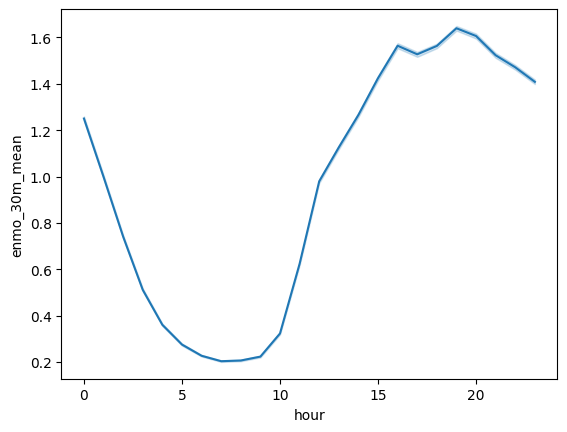

In [27]:
import seaborn as sns

sns.lineplot(train_data, x=X_train['hour'], y=X_train['enmo_30m_mean'])
plt.show()

In [55]:
X_train[feature_cols]

hour,enmo_fft,enmo_5m_mean,enmo_5m_max,enmo_30m_mean,enmo_30m_max
u8,f32,f32,f32,f32,f32
19,56.945469,0.486818,0.248166,0.407491,0.13926
19,0.562466,0.292091,0.046756,0.407491,0.13926
19,0.243926,0.365114,0.20141,0.378384,0.113023
20,0.008978,0.316432,0.071932,0.436597,0.157425
20,0.097316,0.389455,0.280536,0.523917,0.248247
20,0.039804,0.5355,0.442384,0.98962,1.110045
20,0.041618,1.192705,0.992666,2.241199,2.389625
20,0.017248,3.042614,1.999718,3.696523,2.468337
20,0.130402,5.914843,4.39866,3.871162,2.468337


### Training and validating random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Training classifier
rf_classifier = RandomForestClassifier(n_estimators=500,
                                    min_samples_leaf=300,
                                    random_state=42,
                                    n_jobs=-1)

rf_classifier.fit(X_train[feature_cols], y_train)

RandomForestClassifier(min_samples_leaf=300, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [17]:
# Plotting feature importances
px.bar(x=feature_cols, 
       y=rf_classifier.feature_importances_,
       title='Random forest feature importances'
      )

In [ ]:
# Checking performance on validation set
# rf_submission = get_events(val_data, rf_classifier)

# print(f"Random forest score: {score(val_solution, rf_submission, tolerances, **column_names)}")

In [18]:
# Saving classifier 
import pickle
with open('rf_classifier_5m_8h.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

#with open('rf_classifier.pkl', 'rb') as f:
#    rf_classifier = pickle.load(f)

### Training and validating gradient boost

In [ ]:
'''# With SKL
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gb_classifier.fit(X_train[feature_cols], y_train)'''

In [ ]:
'''# Plotting feature importances
px.bar(x=feature_cols, 
       y=gb_classifier.feature_importances_,
       title='Gradient boosting feature importances'
      )'''

In [ ]:
'''
# Checking performance on validation set
gb_submission = get_events(val_data, gb_classifier)

print(f"Gradient boosting score: {score(val_solution, gb_submission, tolerances, **column_names)}")
'''

## Applying to test data

In [19]:
# Recovering memory
del train_data 

In [20]:
# Getting event predictions for test set and saving submission
submission = get_events(test_series.collect(), rf_classifier)
submission.to_csv('submission.csv', index=False)

100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


In [21]:
test_series.fetch(10)

series_id,step,timestamp,hour,enmo_fft,enmo_5m_mean,enmo_5m_max,enmo_30m_mean,enmo_30m_max
str,u32,"datetime[μs, UTC]",u8,i64,u16,u16,u16,u16
"""038441c925bb""",0,2018-08-14 19:30:00 UTC,19,211,21,22,21,22
"""038441c925bb""",1,2018-08-14 19:30:05 UTC,19,0,21,22,21,22
"""038441c925bb""",2,2018-08-14 19:30:10 UTC,19,0,21,22,21,22
"""038441c925bb""",3,2018-08-14 19:30:15 UTC,19,0,21,22,21,22
"""038441c925bb""",4,2018-08-14 19:30:20 UTC,19,0,21,22,21,22
"""038441c925bb""",5,2018-08-14 19:30:25 UTC,19,0,21,22,21,22
"""038441c925bb""",6,2018-08-14 19:30:30 UTC,19,0,21,22,21,22
"""038441c925bb""",7,2018-08-14 19:30:35 UTC,19,0,21,22,21,22
"""038441c925bb""",8,2018-08-14 19:30:40 UTC,19,0,21,22,21,22
